In [21]:
import os
import cv2
import tqdm
import itertools
import numpy as np
from tqdm.contrib import tzip
import matplotlib.pyplot as plt
from scipy.ndimage.filters import convolve
from sklearn.model_selection import train_test_split

In [22]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset

In [23]:
from PIL import Image
from skimage.filters import gaussian
from PIL import Image
from skimage.filters import gaussian
import cv2
from skimage.filters import threshold_yen
from skimage.exposure import rescale_intensity
from skimage.io import imread, imsave
import numpy as np
import torch
from scipy.ndimage.filters import convolve

In [26]:
def equalizeHistnorm(img):
    r_image, g_image, b_image = cv2.split(img)

    r_image_eq = cv2.equalizeHist(r_image)
    g_image_eq = cv2.equalizeHist(g_image)
    b_image_eq = cv2.equalizeHist(b_image)

    image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))
    return image_eq

equalizeHistnorm:

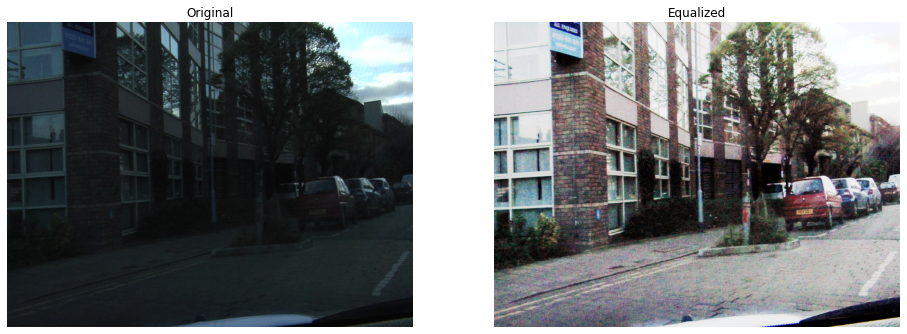

In [50]:
pic = imread('../../data/part_A/camvid/images/0001TP_010020.png')

fig = plt.figure(figsize=(16, 28))

ax1 = fig.add_subplot(2, 2, 1)
ax1.axis("off")
ax1.title.set_text('Original')
ax2 = fig.add_subplot(2, 2, 2)
ax2.axis("off")
ax2.title.set_text("Equalized")

ax1.imshow(pic, cmap=None)
ax2.imshow(equalizeHistnorm(pic), cmap=None)
fig.savefig('./saved_images/equalizeHistnorm.png', dpi=100)

In [5]:
class Data_reader():
    def __init__(self, DATA_PATH = '../../data/part_A/camvid/', labels = False):
        
        self.DATA_PATH = DATA_PATH
        
        self.label_map = {}
        self.color_map = []
        self.reverse_translate = {}

        txt = open(DATA_PATH + 'label_colors.txt').readlines()
        for line in txt:
            self.label_map[line[:-1].split('\t')[-1]] = line.split('\t')[0].split(' ')
            self.color_map.append(line.split('\t')[0].replace(" ", ""))
        l = 0
        for i, j in self.label_map.items():
            self.reverse_translate[l] = [int(k) for k in j]
            l += 1
        if labels:
            print('Number of colors:', len(self.color_map))
            for i, j in self.label_map.items():
                print(i, j)
            for i, j in self.reverse_translate.items():
                print(i, j)
                
                
        self.labels_count = [0 for i in range(len(self.color_map))]
        
    def rev_translate(self, res):
        mask = []
        for i in range(res.shape[1]):
            mask_temp = []
            for j in range(res.shape[2]):
                mask_temp.append(self.reverse_translate[int(res[0][i][j])])
            mask.append(mask_temp)
        return mask
    
    def color_translate(self, color):
        if len(color) > 3:
            print('err: error in color_translate')
        code = str(color[0]) + str(color[1]) + str(color[2])
        color_code = self.color_map.index(code)
        if not code in self.color_map:
            print('err: label color is not defined', code)
            color_code = self.color_map.index('000')
        if color_code > 31 or color_code < 0:
            print('err: label color is not defined', code)
        self.labels_count[self.color_map.index(code)] += 1
        return color_code

    def one_hot(self, pic):
        label = np.zeros([210, 280])
        for i in range(210):
            for j in range(280):
                label[i, j] = self.color_translate(pic[i][j])
        return label
    
    def labels_probability(self):
        values = np.array(self.labels_count)
        p_values = values/np.sum(values)
        return torch.Tensor(p_values)
    
    def load_data(self, split = True, data_shape_log = False):
        
        DATA_PATH = self.DATA_PATH
        data = []
        labels = []

        ims = [DATA_PATH + 'images/' + i for i in os.listdir(DATA_PATH + 'images/')]
        lbs = [DATA_PATH + 'labels/' + i[:-4] + '_L' + i[-4:] for i in os.listdir(DATA_PATH + 'images/')]

        if(len(ims) != len(lbs)):
            print('err: size of images and labels are not the same.')

        print('Images size:', cv2.imread(ims[0]).shape)

        plt.imshow(equalizeHistnorm(imread(ims[0])))
        plt.show()
        plt.imshow(equalizeHistnorm(imread(lbs[0])))
        plt.show()


        for i, j in tzip(ims, lbs):
            try:
                datum = cv2.resize(cv2.imread(i), (280, 210))
                datum = equalizeHistnorm(datum)
                label = self.one_hot(cv2.resize(imread(j), (280, 210), interpolation=cv2.INTER_NEAREST))
                data.append(datum)
                labels.append(label)
            except:
                continue
        
        if not split:
            return data, labels
        
        X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.42, random_state=42)
        
        if data_shape_log:
            print('data size:\t', len(data), len(labels))
            print('X_train:\ttraining images shape\t', len(X_train), X_train[0].shape)
            print('X_test:\t\ttest images shape\t', len(X_test), X_test[0].shape)
            print('Y_train:\ttraining labels shape\t', len(Y_train), Y_train[0].shape)
            print('Y_test:\t\ttest labels shape\t', len(Y_test), Y_test[0].shape)
        
        return X_train, X_test, Y_train, Y_test

In [6]:
class CamvidDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform):
        self.X = X
        self.y = y
        self.transform = transform
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        image = self.X[index]
        label = self.y[index]
        image = self.transform(image)
        return image, label

In [7]:
def imshow(img, t = ''):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(t)
    plt.show()